# Headers

In [1]:
import pandas as pd
from main import *


In [2]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from pytorch_lightning import Trainer
from pytorch_forecasting.models import TemporalFusionTransformer

import torch

/anaconda/envs/nec10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

##  Data Cleaning

In [3]:
group_cols = ["SALES_ORG_NAME", "FABRIC_TYPE", "SEASON_CONSOLIDATION"]

In [4]:
'''
group_cols = ["SALES_ORG_NAME", "SILHOUETTE"]
group_cols = ["SALES_ORG_NAME", "SILHOUETTE", "FABRIC_TYPE"]
group_cols = ["SALES_ORG_NAME", "SILHOUETTE", "FABRIC_TYPE", "SEASON_CONSOLIDATION"]
'''

'\ngroup_cols = ["SALES_ORG_NAME", "SILHOUETTE"]\ngroup_cols = ["SALES_ORG_NAME", "SILHOUETTE", "FABRIC_TYPE"]\ngroup_cols = ["SALES_ORG_NAME", "SILHOUETTE", "FABRIC_TYPE", "SEASON_CONSOLIDATION"]\n'

In [5]:
import pandas as pd
import numpy as np
import torch

import pytorch_lightning as pl
from torch.utils.data import DataLoader

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss

pl.seed_everything(42)
torch.set_float32_matmul_precision("medium")


Global seed set to 42


In [6]:
df_main = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/snowflake_v5_pre_ts.csv')

# Drop unnecessary columns
df_main = df_main.drop(columns=['SALES_ORG','REGION','COUNTRY','FABRIC_CONTENT_CODE_TEXT','TEAM','SILHOUETTE','SPORT','DIVISION_NAME',], errors='ignore')
df_main.head()

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,20231003,Japan,Wovens,Custom,72
1,20231003,Japan,Wovens,Custom,72
2,20231109,New Zealand,Wovens,Program,80
3,20231103,United States,Wovens,Program,1
4,20231103,United States,Wovens,Program,1


In [7]:
df_main = df_main[~df_main['SALES_ORG_NAME'].isin(['47 Japan','47 New Zealand','47 UK','47 Australia'])]

In [8]:
top_fabrics = (
    df_main.groupby(['FABRIC_TYPE','SALES_ORG_NAME'])['ORDERED_QUANTITY']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

print("Top 10 Silhouettes:")
print(top_fabrics)


Top 10 Silhouettes:
FABRIC_TYPE  SALES_ORG_NAME
Wovens       United States     2500776
Other        United States     2483034
Knits        United States      536493
Wovens       EMEA               388721
Other        EMEA               223943
Knits        5th & Ocean        170825
             EMEA               152110
Other        Canada             138100
Wovens       Japan              123200
             Southeast Asia     120300
Name: ORDERED_QUANTITY, dtype: int64


In [9]:
df_main = df_main[df_main['FABRIC_TYPE'].isin(['Wovens','Knits'])]
df_main.head()

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,20231003,Japan,Wovens,Custom,72
1,20231003,Japan,Wovens,Custom,72
2,20231109,New Zealand,Wovens,Program,80
3,20231103,United States,Wovens,Program,1
4,20231103,United States,Wovens,Program,1


In [10]:
'''
top_regions = (
    df_main.groupby('REGION')['ORDERED_QUANTITY']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

print("Top Regions:")
print(top_regions)
'''

'\ntop_regions = (\n    df_main.groupby(\'REGION\')[\'ORDERED_QUANTITY\']\n    .count()\n    .sort_values(ascending=False)\n    .head(10)\n)\n\nprint("Top Regions:")\nprint(top_regions)\n'

In [11]:
top_sales_org_name = (
    df_main.groupby('SALES_ORG_NAME')['ORDERED_QUANTITY']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

print("Top Sales Org Name:")
print(top_sales_org_name)


Top Sales Org Name:
SALES_ORG_NAME
United States     3037269
EMEA               540831
5th & Ocean        275242
Southeast Asia     171694
Canada             141863
Japan              123381
Latin America      122683
Australia           94779
South Korea         79809
Mexico              61012
Name: ORDERED_QUANTITY, dtype: int64


# Choose Data

In [12]:
df_main_us = df_main[df_main['SALES_ORG_NAME'] == 'United States']

# Model Prep US

## Data Prep

In [13]:
df_main_us['PO_CREATED_DATE'] = pd.to_datetime(df_main_us['PO_CREATED_DATE'], format='%Y%m%d')
df_main_us = df_main_us[(df_main_us['PO_CREATED_DATE'] >= '2009-01-01') & (df_main_us['PO_CREATED_DATE'] < '2026-01-01')]

/tmp/ipykernel_87772/3164968372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main_us['PO_CREATED_DATE'] = pd.to_datetime(df_main_us['PO_CREATED_DATE'], format='%Y%m%d')


In [14]:
df_main
(df_main_us.tail())

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
7742597,2024-07-26,United States,Wovens,Program,1
7742599,2024-08-01,United States,Knits,Program,1
7742602,2022-01-26,United States,Wovens,Custom,12
7742603,2022-02-01,United States,Knits,Custom,36
7742607,2010-09-08,United States,Wovens,Custom,30


In [15]:
df_main_us = df_main_us.drop(columns=['SALES_ORG_NAME'])

In [16]:
print(df_main_us.head())

  PO_CREATED_DATE FABRIC_TYPE SEASON_CONSOLIDATION  ORDERED_QUANTITY
3      2023-11-03      Wovens              Program                 1
4      2023-11-03      Wovens              Program                 1
5      2023-10-25      Wovens               Custom                 2
6      2023-10-25      Wovens               Custom                27
9      2023-10-24      Wovens               Custom               864


In [17]:
top_sales_org_name = (
    df_main_us.groupby(['FABRIC_TYPE','SEASON_CONSOLIDATION'])['ORDERED_QUANTITY']
    .count()
    .sort_values(ascending=False)
)

print("Top Sales Org Name:")
print(top_sales_org_name)


Top Sales Org Name:
FABRIC_TYPE  SEASON_CONSOLIDATION
Wovens       Custom                  1697630
             Program                  745309
Knits        Program                  332286
             Custom                   200408
Wovens       Stock                     57837
Knits        Stock                      3799
Name: ORDERED_QUANTITY, dtype: int64


In [18]:
df = df_main_us[(df_main_us['PO_CREATED_DATE'] >= '2010-01-01') & (df_main_us['PO_CREATED_DATE'] < '2025-01-01')]
df['DATE'] = df['PO_CREATED_DATE'].dt.to_period('M').dt.to_timestamp()
df = df.drop(columns=['PO_CREATED_DATE'])
print(df.tail())

        FABRIC_TYPE SEASON_CONSOLIDATION  ORDERED_QUANTITY       DATE
7742597      Wovens              Program                 1 2024-07-01
7742599       Knits              Program                 1 2024-08-01
7742602      Wovens               Custom                12 2022-01-01
7742603       Knits               Custom                36 2022-02-01
7742607      Wovens               Custom                30 2010-09-01


/tmp/ipykernel_87772/3194021202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE'] = df['PO_CREATED_DATE'].dt.to_period('M').dt.to_timestamp()


In [19]:
df_ts = df.groupby(['DATE','FABRIC_TYPE','SEASON_CONSOLIDATION'])['ORDERED_QUANTITY'].sum().reset_index()


print("Top Sales Org Name:")
print(df_ts.head())


Top Sales Org Name:
        DATE FABRIC_TYPE SEASON_CONSOLIDATION  ORDERED_QUANTITY
0 2010-01-01       Knits               Custom              9819
1 2010-01-01      Wovens               Custom           3596359
2 2010-01-01      Wovens              Program            207994
3 2010-01-01      Wovens                Stock              2148
4 2010-02-01       Knits               Custom             74568


In [20]:
cat_cols = ['FABRIC_TYPE', 'SEASON_CONSOLIDATION']


missing_dates, pairs = verify_grp_timestamps(df_ts,cat_cols)
missing_dates

,Group,Year,Missing Months
0,"(Knits, Program)",2010,"[1, 2]"
1,"(Knits, Stock)",2010,"[1, 2, 3, 4, 5, 6, 7, 8, 9]"
2,"(Knits, Stock)",2011,"[2, 5, 7, 8, 9, 10, 11, 12]"
3,"(Knits, Stock)",2012,"[1, 3, 11]"
4,"(Knits, Stock)",2013,"[8, 9, 10, 11, 12]"
5,"(Knits, Stock)",2014,"[1, 2, 3, 4, 5, 7, 9, 12]"
6,"(Knits, Stock)",2015,"[1, 2, 3, 4, 5, 7, 10, 11]"
7,"(Knits, Stock)",2016,"[1, 3, 4, 5]"
8,"(Knits, Stock)",2017,"[2, 10, 11]"
9,"(Knits, Stock)",2018,"[1, 2, 3, 4, 9, 10]"


We Decide to drop the grou Knits and Stock, as majority of the data is missing 

The Wovens and Stock missing value which is 2012 would be filled with 0 or Avg value from last year

In [21]:
df_final = df_ts[~((df_ts['FABRIC_TYPE'] == 'Knits') & (df_ts['SEASON_CONSOLIDATION'] == 'Stock'))]

In [22]:
missing_dates_df_final, pairs_final = verify_grp_timestamps(df_final,cat_cols)

In [23]:
missing_dates_df_final

,Group,Year,Missing Months
0,"(Knits, Program)",2010,"[1, 2]"
1,"(Wovens, Stock)",2010,[2]
2,"(Wovens, Stock)",2012,"[7, 11]"


In [24]:
def fill_missing_months_inplace(df, cat_cols, date_col="DATE"):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    all_filled_rows = []  # to store newly created rows

    # Step 1: group by categorical columns dynamically
    for key, group_df in df.groupby(cat_cols):
        
        # get min/max date for the group
        full_range = pd.date_range(
            start=group_df[date_col].min(),
            end=group_df[date_col].max(),
            freq="MS"
        )

        # existing dates
        existing_dates = set(group_df[date_col])

        # Step 2: find missing dates
        missing_dates = [d for d in full_range if d not in existing_dates]

        # Step 3: create rows for missing dates
        for d in missing_dates:
            new_row = {col: val for col, val in zip(cat_cols, key)}
            new_row[date_col] = d
            new_row["ORDERED_QUANTITY"] = 0  # or 0 or np.nan
            all_filled_rows.append(new_row)

    # Step 4: add missing rows to original df
    df_filled = pd.concat([df, pd.DataFrame(all_filled_rows)], ignore_index=True)

    # Step 5: sort final df
    df_filled = df_filled.sort_values(cat_cols + [date_col]).reset_index(drop=True)

    return df_filled


In [25]:
df_filled = fill_missing_months_inplace(df_final,cat_cols)


In [26]:
df_check,pairs = verify_grp_timestamps(df_filled,cat_cols)

In [27]:
df_check

,Group,Year,Missing Months
0,"(Knits, Program)",2010,"[1, 2]"


In [28]:
pairs

[('Knits', 'Custom'),
 ('Knits', 'Program'),
 ('Wovens', 'Custom'),
 ('Wovens', 'Program'),
 ('Wovens', 'Stock')]

In [29]:
df_filled = fill_missing_months_inplace(df_final,cat_cols)
df_filled

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2010-01-01,Knits,Custom,9819
1,2010-02-01,Knits,Custom,74568
2,2010-03-01,Knits,Custom,13106
3,2010-04-01,Knits,Custom,105442
4,2010-05-01,Knits,Custom,93164
...,...,...,...,...
893,2024-08-01,Wovens,Stock,40355
894,2024-09-01,Wovens,Stock,7844
895,2024-10-01,Wovens,Stock,281194
896,2024-11-01,Wovens,Stock,86093


## CatBoost

In [30]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np

In [31]:
cat_cols = ['FABRIC_TYPE','SEASON_CONSOLIDATION']

In [98]:
df = df_filled.copy()
df.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2010-01-01,Knits,Custom,9819
1,2010-02-01,Knits,Custom,74568
2,2010-03-01,Knits,Custom,13106
3,2010-04-01,Knits,Custom,105442
4,2010-05-01,Knits,Custom,93164


In [99]:
df

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2010-01-01,Knits,Custom,9819
1,2010-02-01,Knits,Custom,74568
2,2010-03-01,Knits,Custom,13106
3,2010-04-01,Knits,Custom,105442
4,2010-05-01,Knits,Custom,93164
...,...,...,...,...
893,2024-08-01,Wovens,Stock,40355
894,2024-09-01,Wovens,Stock,7844
895,2024-10-01,Wovens,Stock,281194
896,2024-11-01,Wovens,Stock,86093


In [35]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np

In [100]:
group_cols = ['FABRIC_TYPE','SEASON_CONSOLIDATION']
cap_q = 0.99

def cap_group(g):
    cap_value = g['ORDERED_QUANTITY'].quantile(cap_q)
    print(f"Outlier cap ({cap_q}) for group {g.name}: {cap_value:,.0f}")
    g['ORDERED_QUANTITY'] = g['ORDERED_QUANTITY'].clip(upper=cap_value)
    return g

df = df.groupby(group_cols).apply(cap_group).reset_index(drop=True)


Outlier cap (0.99) for group ('Knits', 'Custom'): 1,079,460
Outlier cap (0.99) for group ('Knits', 'Program'): 2,484,967
Outlier cap (0.99) for group ('Wovens', 'Custom'): 6,174,172
Outlier cap (0.99) for group ('Wovens', 'Program'): 3,582,014
Outlier cap (0.99) for group ('Wovens', 'Stock'): 996,941


/tmp/ipykernel_87772/971249282.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby(group_cols).apply(cap_group).reset_index(drop=True)


In [101]:
# Create Lags

lag_groups = [
    'FABRIC_TYPE','SEASON_CONSOLIDATION']

df_ts = df_filled.sort_values(lag_groups + ['DATE'])

for lag in [1, 2, 3, 6, 12]:
    df_ts[f'lag_{lag}'] = (
        df_ts.groupby(lag_groups)['ORDERED_QUANTITY'].shift(lag)
    )

# =============================
# 3. Rolling means (shifted)
# =============================

for window in [3, 6, 12]:
    df_ts[f'rollmean_{window}'] = (
        df_ts.groupby(lag_groups)['ORDERED_QUANTITY']
        .transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    )

# Exponential weighted moving average
for span in [3, 6, 12]:
    df_ts[f'ewm_{span}'] = (
        df_ts['ORDERED_QUANTITY'].shift(1).ewm(span=span).mean()
    )

# Momentum features (rate of change)
df_ts['momentum_3m'] = df_ts['lag_1'] - df_ts['lag_3']
df_ts['momentum_12m'] = df_ts['lag_1'] - df_ts['lag_12']

# Year-over-year comparison
df_ts['yoy_change'] = df_ts['lag_1'] - df_ts['lag_12']
df_ts['yoy_pct'] = df_ts['yoy_change'] / (df_ts['lag_12'] + 1)

df_ts.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12,ewm_3,ewm_6,ewm_12,momentum_3m,momentum_12m,yoy_change,yoy_pct
0,2010-01-01,Knits,Custom,9819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-01,Knits,Custom,74568,9819.0,NaN,NaN,NaN,NaN,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,NaN,NaN,NaN,NaN
2,2010-03-01,Knits,Custom,13106,74568.0,9819.0,NaN,NaN,NaN,42193.500000,42193.500000,42193.500000,52985.000000,47589.250000,44891.375000,NaN,NaN,NaN,NaN
3,2010-04-01,Knits,Custom,105442,13106.0,74568.0,9819.0,NaN,NaN,32497.666667,32497.666667,32497.666667,30197.000000,32087.605505,32485.535797,3287.0,NaN,NaN,NaN
4,2010-05-01,Knits,Custom,93164,105442.0,13106.0,74568.0,NaN,NaN,64372.000000,50733.750000,50733.750000,70327.666667,60421.566441,55515.040374,30874.0,NaN,NaN,NaN


In [102]:
df_ts = df_ts[df_ts['DATE'] >= '2011-01-01']
df_ts.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12,ewm_3,ewm_6,ewm_12,momentum_3m,momentum_12m,yoy_change,yoy_pct
12,2011-01-01,Knits,Custom,35934,32186.0,67580.0,40626.0,72585.0,9819.0,46797.333333,55197.833333,52803.000000,45948.593651,50500.978853,52466.125928,-8440.0,22367.0,22367.0,2.277699
13,2011-02-01,Knits,Custom,45053,35934.0,32186.0,67580.0,42311.0,74568.0,45233.333333,49089.333333,54979.250000,40940.685508,46285.878917,49595.520820,-31646.0,-38634.0,-38634.0,-0.518097
14,2011-03-01,Knits,Custom,34005,45053.0,35934.0,32186.0,75899.0,13106.0,37724.333333,49546.333333,52519.666667,42996.968260,45930.429007,48822.074559,12867.0,31947.0,31947.0,2.437400
15,2011-04-01,Knits,Custom,71380,34005.0,45053.0,35934.0,40626.0,105442.0,38330.666667,42564.000000,54261.250000,38500.846919,42501.119794,46339.960911,-1929.0,-71437.0,-71437.0,-0.677494
16,2011-05-01,Knits,Custom,56011,71380.0,34005.0,45053.0,67580.0,93164.0,50146.000000,47689.666667,51422.750000,54940.674311,50790.287863,50478.024800,26327.0,-21784.0,-21784.0,-0.233822


In [103]:
# =============================
# 4. Seasonality
# =============================

df_ts['month'] = df_ts['DATE'].dt.month
df_ts['month_sin'] = np.sin(2 * np.pi * df_ts['month'] / 12)
df_ts['month_cos'] = np.cos(2 * np.pi * df_ts['month'] / 12)
#df_ts['quarter'] = df_ts['DATE'].dt.quarter

df_ts['ORDERED_QUANTITY_log'] = np.log1p(df_ts['ORDERED_QUANTITY'])

In [104]:
# =============================
# 6. Train/Test Split
# =============================

train = df_ts[df_ts['DATE'] < '2024-01-01']
test  = df_ts[(df_ts['DATE'] >= '2024-01-01') & 
                   (df_ts['DATE'] < '2025-01-01')]

drop_cols = ['ORDERED_QUANTITY', 'ORDERED_QUANTITY_log', 'DATE','month']
X_train = train.drop(columns=drop_cols)
y_train = train['ORDERED_QUANTITY_log']

X_test = test.drop(columns=drop_cols)
y_test = np.expm1(test['ORDERED_QUANTITY_log'])



In [105]:
# =============================
# 7. Identify categorical columns
# =============================

cat_cols = X_train.select_dtypes(include='object').columns.tolist()
cat_cols

['FABRIC_TYPE', 'SEASON_CONSOLIDATION']

In [106]:
# =============================
# 8. Train CatBoost
# =============================

#train_dir = "/Volumes/Kaam-Dhanda/NewEra/catboost_info"
model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.05,
    depth=10,
    loss_function='MAE',
    l2_leaf_reg=3,
    random_seed=42,
    task_type='CPU',   # change to GPU if you have one
    verbose=100,
    #train_dir=train_dir
)

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool  = Pool(X_test, cat_features=cat_cols)

model.fit(train_pool)

0:	learn: 1.3319185	total: 19.2ms	remaining: 28.8s
100:	learn: 0.4028120	total: 1.98s	remaining: 27.5s
200:	learn: 0.2226962	total: 3.98s	remaining: 25.7s
300:	learn: 0.1220364	total: 6.13s	remaining: 24.4s
400:	learn: 0.0831964	total: 8.29s	remaining: 22.7s
500:	learn: 0.0611983	total: 10.2s	remaining: 20.4s
600:	learn: 0.0444137	total: 12.3s	remaining: 18.4s
700:	learn: 0.0343786	total: 14.3s	remaining: 16.4s
800:	learn: 0.0272050	total: 16.4s	remaining: 14.3s
900:	learn: 0.0215220	total: 18.6s	remaining: 12.3s
1000:	learn: 0.0178095	total: 20.5s	remaining: 10.2s
1100:	learn: 0.0147905	total: 22.7s	remaining: 8.21s
1200:	learn: 0.0127489	total: 24.6s	remaining: 6.12s
1300:	learn: 0.0108615	total: 26.7s	remaining: 4.09s
1400:	learn: 0.0094891	total: 28.7s	remaining: 2.03s
1499:	learn: 0.0081158	total: 30.8s	remaining: 0us


In [107]:
# =============================
# 9. Predict
# =============================

y_pred_log = model.predict(test_pool)
y_pred = np.expm1(y_pred_log)
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

# =============================
# 10. Metrics
# =============================


mae = np.mean(np.abs(y_test - y_pred))
wape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))

print("MAE:", mae)
print("RMSE:", rmse)
print("WAPE:", wape * 100)
print("Accuracy:", 100 - wape * 100)

MAE: 292789.25
RMSE: 518982.50440059794
WAPE: 38.88321870316074
Accuracy: 61.11678129683926


In [108]:
y_pred = pd.DataFrame(y_pred)

In [109]:
plot_df = test.copy().reset_index().drop(columns=['index'])
plot_df.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,...,ewm_6,ewm_12,momentum_3m,momentum_12m,yoy_change,yoy_pct,month,month_sin,month_cos,ORDERED_QUANTITY_log
0,2024-01-01,Knits,Custom,492754,226606.0,292977.0,595448.0,65273.0,494500.0,371677.000000,...,306067.432907,345507.316307,-368842.0,-267894.0,-267894.0,-0.541746,1,0.500000,8.660254e-01,13.107767
1,2024-02-01,Knits,Custom,221276,492754.0,226606.0,292977.0,214419.0,266318.0,337445.666667,...,359406.452077,368160.652260,199777.0,226436.0,226436.0,0.850244,2,0.866025,5.000000e-01,12.307171
2,2024-03-01,Knits,Custom,458416,221276.0,492754.0,226606.0,275076.0,561480.0,313545.333333,...,319940.608626,345563.013451,-5330.0,-340204.0,-340204.0,-0.605905,3,1.000000,6.123234e-17,13.035535
3,2024-04-01,Knits,Custom,317406,458416.0,221276.0,492754.0,595448.0,525628.0,390815.333333,...,359505.006162,362925.011381,-34338.0,-67212.0,-67212.0,-0.127870,4,0.866025,-5.000000e-01,12.667940
4,2024-05-01,Knits,Custom,882522,317406.0,458416.0,221276.0,292977.0,301521.0,332366.000000,...,347476.718687,355922.086554,96130.0,15885.0,15885.0,0.052683,5,0.500000,-8.660254e-01,13.690540


In [110]:
plot_df['y_pred'] = y_pred
plot_df.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,...,ewm_12,momentum_3m,momentum_12m,yoy_change,yoy_pct,month,month_sin,month_cos,ORDERED_QUANTITY_log,y_pred
0,2024-01-01,Knits,Custom,492754,226606.0,292977.0,595448.0,65273.0,494500.0,371677.000000,...,345507.316307,-368842.0,-267894.0,-267894.0,-0.541746,1,0.500000,8.660254e-01,13.107767,402105
1,2024-02-01,Knits,Custom,221276,492754.0,226606.0,292977.0,214419.0,266318.0,337445.666667,...,368160.652260,199777.0,226436.0,226436.0,0.850244,2,0.866025,5.000000e-01,12.307171,315968
2,2024-03-01,Knits,Custom,458416,221276.0,492754.0,226606.0,275076.0,561480.0,313545.333333,...,345563.013451,-5330.0,-340204.0,-340204.0,-0.605905,3,1.000000,6.123234e-17,13.035535,506943
3,2024-04-01,Knits,Custom,317406,458416.0,221276.0,492754.0,595448.0,525628.0,390815.333333,...,362925.011381,-34338.0,-67212.0,-67212.0,-0.127870,4,0.866025,-5.000000e-01,12.667940,246602
4,2024-05-01,Knits,Custom,882522,317406.0,458416.0,221276.0,292977.0,301521.0,332366.000000,...,355922.086554,96130.0,15885.0,15885.0,0.052683,5,0.500000,-8.660254e-01,13.690540,274424


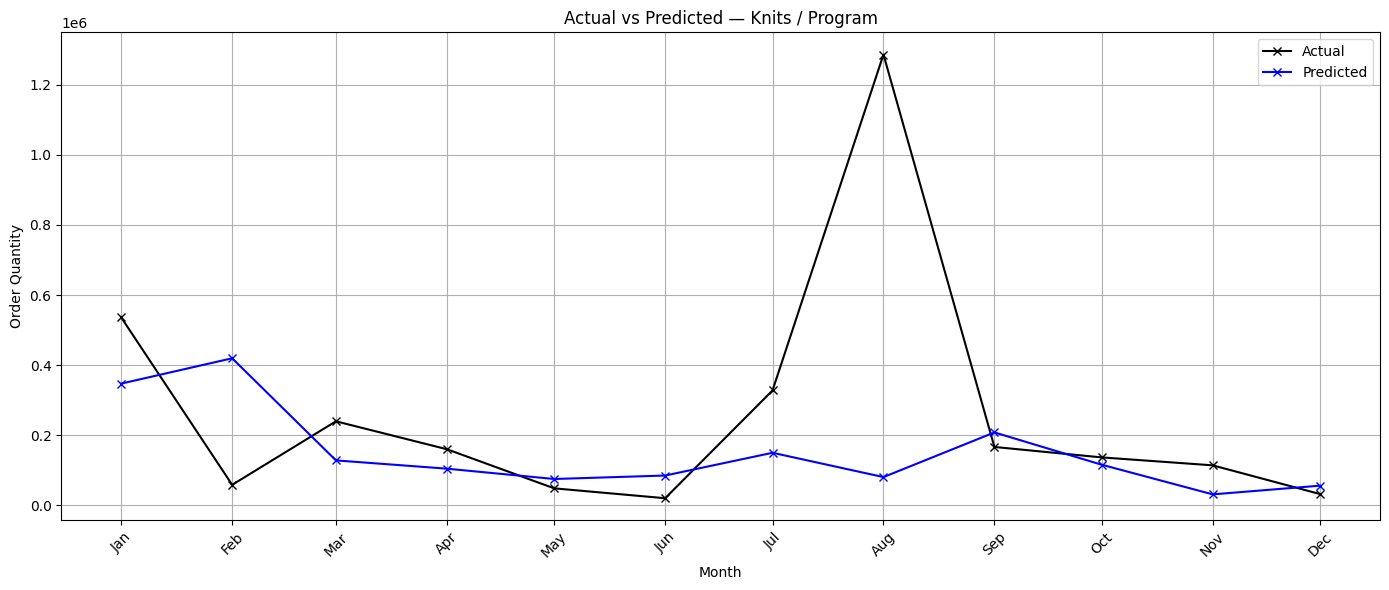

In [111]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fabrics = 'Knits'
season = 'Program'

df_pivot = plot_df[(plot_df['FABRIC_TYPE'] == fabrics) &
                   (plot_df['SEASON_CONSOLIDATION'] == season)]

df_pivot = df_pivot.sort_values("DATE")

plt.figure(figsize=(14,6))

plt.plot(df_pivot['DATE'], df_pivot['ORDERED_QUANTITY'], 
         'x-',label="Actual", color="black")
plt.plot(df_pivot['DATE'], df_pivot['y_pred'], 
         'x-',label="Predicted", color="blue")

# ★ Show month names
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))   # ← Month name + Year
plt.xticks(rotation=45)

plt.title(f"Actual vs Predicted — {fabrics} / {season}")
plt.xlabel("Month")
plt.ylabel("Order Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
calculate_metrics(test,y_pred,pairs,cat_cols)

,group,MAE,RMSE,WAPE,COUNT
0,"(Knits, Custom)",167734.50,230638.10,47.76,12
1,"(Knits, Program)",196853.33,374486.53,75.58,12
2,"(Wovens, Custom)",785131.33,992212.09,33.46,12
3,"(Wovens, Program)",238347.58,395688.55,34.36,12
4,"(Wovens, Stock)",75880.00,110576.39,67.01,12


## CatBoost - Quantiles

In [383]:
cat_cols = ['FABRIC_TYPE','SEASON_CONSOLIDATION']

In [384]:
df = df_filled.copy()
df.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2010-01-01,Knits,Custom,9819
1,2010-02-01,Knits,Custom,74568
2,2010-03-01,Knits,Custom,13106
3,2010-04-01,Knits,Custom,105442
4,2010-05-01,Knits,Custom,93164


In [385]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np

In [386]:
# Create Lags

lag_groups = [
    'FABRIC_TYPE','SEASON_CONSOLIDATION']

df_ts = df_filled.sort_values(lag_groups + ['DATE'])

for lag in [1, 2, 3, 6, 12]:
    df_ts[f'lag_{lag}'] = (
        df_ts.groupby(lag_groups)['ORDERED_QUANTITY'].shift(lag)
    )

# =============================
# 3. Rolling means (shifted)
# =============================

for window in [3, 6, 12]:
    df_ts[f'rollmean_{window}'] = (
        df_ts.groupby(lag_groups)['ORDERED_QUANTITY']
        .transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    )

df_ts.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12
0,2010-01-01,Knits,Custom,9819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-01,Knits,Custom,74568,9819.0,NaN,NaN,NaN,NaN,9819.000000,9819.000000,9819.000000
2,2010-03-01,Knits,Custom,13106,74568.0,9819.0,NaN,NaN,NaN,42193.500000,42193.500000,42193.500000
3,2010-04-01,Knits,Custom,105442,13106.0,74568.0,9819.0,NaN,NaN,32497.666667,32497.666667,32497.666667
4,2010-05-01,Knits,Custom,93164,105442.0,13106.0,74568.0,NaN,NaN,64372.000000,50733.750000,50733.750000


In [387]:
df_ts = df_ts[df_ts['DATE'] >= '2011-01-01']
df_ts.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12
12,2011-01-01,Knits,Custom,35934,32186.0,67580.0,40626.0,72585.0,9819.0,46797.333333,55197.833333,52803.000000
13,2011-02-01,Knits,Custom,45053,35934.0,32186.0,67580.0,42311.0,74568.0,45233.333333,49089.333333,54979.250000
14,2011-03-01,Knits,Custom,34005,45053.0,35934.0,32186.0,75899.0,13106.0,37724.333333,49546.333333,52519.666667
15,2011-04-01,Knits,Custom,71380,34005.0,45053.0,35934.0,40626.0,105442.0,38330.666667,42564.000000,54261.250000
16,2011-05-01,Knits,Custom,56011,71380.0,34005.0,45053.0,67580.0,93164.0,50146.000000,47689.666667,51422.750000


In [388]:
# =============================
# 4. Seasonality
# =============================

df_ts['month'] = df_ts['DATE'].dt.month
df_ts['month_sin'] = np.sin(2 * np.pi * df_ts['month'] / 12)
df_ts['month_cos'] = np.cos(2 * np.pi * df_ts['month'] / 12)
df_ts['quarter'] = df_ts['DATE'].dt.quarter

df_ts['ORDERED_QUANTITY_log'] = np.log1p(df_ts['ORDERED_QUANTITY'])

In [389]:
# =============================
# 6. Train/Test Split
# =============================

train = df_ts[df_ts['DATE'] < '2024-01-01']
test  = df_ts[(df_ts['DATE'] >= '2024-01-01') & 
                   (df_ts['DATE'] < '2025-01-01')]

drop_cols = ['ORDERED_QUANTITY', 'ORDERED_QUANTITY_log', 'DATE']
X_train = train.drop(columns=drop_cols)
y_train = train['ORDERED_QUANTITY_log']

X_test = test.drop(columns=drop_cols)
y_test = np.expm1(test['ORDERED_QUANTITY_log'])



In [390]:
y_train

12     10.489467
13     10.715617
14     10.434292
15     11.175787
16     10.933321
         ...    
881    12.003179
882     5.796058
883    11.742154
884    12.074688
885    10.119929
Name: ORDERED_QUANTITY_log, Length: 780, dtype: float64

In [391]:
# =============================
# 7. Identify categorical columns
# =============================

cat_cols = X_train.select_dtypes(include='object').columns.tolist()
cat_cols

['FABRIC_TYPE', 'SEASON_CONSOLIDATION']

In [392]:
# =============================
# 8. Train CatBoost
# =============================

from catboost import CatBoostRegressor, Pool

train_dir = "/Volumes/Kaam-Dhanda/NewEra/catboost_info"
def train_quantile_model(alpha, X_train, y_train, cat_cols):
    model = CatBoostRegressor(
        iterations=1500,
        learning_rate=0.05,
        depth=10,
        loss_function=f'Quantile:alpha={alpha}',
        random_seed=42,
        verbose=100,
        train_dir=train_dir
    )
    
    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    model.fit(train_pool)
    return model

In [393]:
model_p10 = train_quantile_model(0.10, X_train, y_train, cat_cols)
model_p50 = train_quantile_model(0.50, X_train, y_train, cat_cols)  # median
model_p90 = train_quantile_model(0.90, X_train, y_train, cat_cols)

0:	learn: 0.3502469	total: 42.9ms	remaining: 1m 4s
100:	learn: 0.0751201	total: 430ms	remaining: 5.95s
200:	learn: 0.0490479	total: 781ms	remaining: 5.05s
300:	learn: 0.0401126	total: 1.21s	remaining: 4.8s
400:	learn: 0.0324116	total: 1.59s	remaining: 4.37s
500:	learn: 0.0273649	total: 1.97s	remaining: 3.92s
600:	learn: 0.0234622	total: 2.43s	remaining: 3.64s
700:	learn: 0.0203951	total: 2.81s	remaining: 3.21s
800:	learn: 0.0182033	total: 3.19s	remaining: 2.78s
900:	learn: 0.0157334	total: 3.57s	remaining: 2.38s
1000:	learn: 0.0141071	total: 3.95s	remaining: 1.97s
1100:	learn: 0.0133091	total: 4.32s	remaining: 1.57s
1200:	learn: 0.0126283	total: 4.7s	remaining: 1.17s
1300:	learn: 0.0119263	total: 5.06s	remaining: 774ms
1400:	learn: 0.0109664	total: 5.45s	remaining: 385ms
1499:	learn: 0.0105382	total: 5.82s	remaining: 0us
0:	learn: 0.6672528	total: 4.31ms	remaining: 6.46s
100:	learn: 0.1885544	total: 387ms	remaining: 5.36s
200:	learn: 0.1021696	total: 764ms	remaining: 4.94s
300:	learn: 

In [395]:
test_pool = Pool(X_test, cat_features=cat_cols)

pred_log_p10 = model_p10.predict(test_pool)
pred_log_p50 = model_p50.predict(test_pool)
pred_log_p90 = model_p90.predict(test_pool)

# Convert from log scale back to original
pred_p10 = np.expm1(pred_log_p10)
pred_p50 = np.expm1(pred_log_p50)
pred_p90 = np.expm1(pred_log_p90)

In [408]:
test.loc[:,'pred_p10'] = pred_p10.astype(int)
test.loc[:,'pred_p50'] = pred_p50.astype(int)
test.loc[:,'pred_p90'] = pred_p90.astype(int)

/var/folders/wn/f9dqwf512q52fzs0t0yk_4jw0000gn/T/ipykernel_143/2669655767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_p10'] = pred_p10.astype(int)
/var/folders/wn/f9dqwf512q52fzs0t0yk_4jw0000gn/T/ipykernel_143/2669655767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_p50'] = pred_p50.astype(int)
/var/folders/wn/f9dqwf512q52fzs0t0yk_4jw0000gn/T/ipykernel_143/2669655767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [409]:
test.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12,month,month_sin,month_cos,quarter,ORDERED_QUANTITY_log,pred_p10,pred_p50,pred_p90
168,2024-01-01,Knits,Custom,492754,226606.0,292977.0,595448.0,65273.0,494500.0,371677.000000,278299.833333,329111.750000,1,0.500000,8.660254e-01,1,13.107767,299157,322470,377019
169,2024-02-01,Knits,Custom,221276,492754.0,226606.0,292977.0,214419.0,266318.0,337445.666667,349546.666667,328966.250000,2,0.866025,5.000000e-01,1,12.307171,347069,340531,510139
170,2024-03-01,Knits,Custom,458416,221276.0,492754.0,226606.0,275076.0,561480.0,313545.333333,350689.500000,325212.750000,3,1.000000,6.123234e-17,1,13.035535,284169,473731,731860
171,2024-04-01,Knits,Custom,317406,458416.0,221276.0,492754.0,595448.0,525628.0,390815.333333,381246.166667,316624.083333,4,0.866025,-5.000000e-01,2,12.667940,199283,379105,653670
172,2024-05-01,Knits,Custom,882522,317406.0,458416.0,221276.0,292977.0,301521.0,332366.000000,334905.833333,299272.250000,5,0.500000,-8.660254e-01,2,13.690540,241246,349697,627796


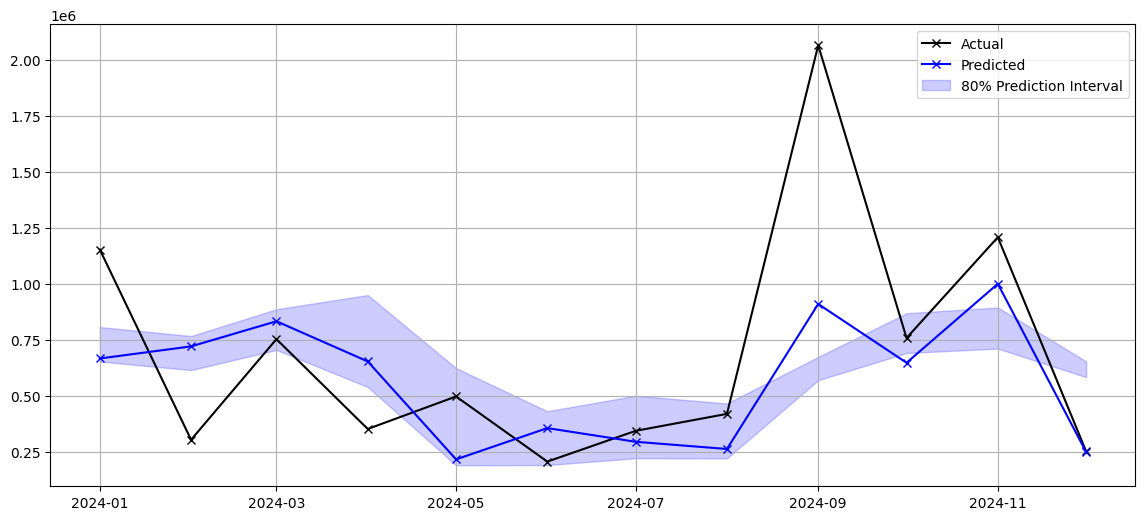

In [417]:
fabrics = 'Wovens'
season = 'Program'

df_pivot = test[(test['FABRIC_TYPE'] == fabrics) &
                   (test['SEASON_CONSOLIDATION'] == season)].copy()

df_pivot = df_pivot.sort_values("DATE")

df_pivot = df_pivot[['DATE','FABRIC_TYPE','SEASON_CONSOLIDATION','ORDERED_QUANTITY','month','pred_p10','pred_p50','pred_p90']]
df_pivot['lower'] = df_pivot[['pred_p10', 'pred_p50', 'pred_p90']].min(axis=1)
df_pivot['upper'] = df_pivot[['pred_p10', 'pred_p50', 'pred_p90']].max(axis=1)

df_pivot['lower'] = df_pivot['lower'].rolling(2, min_periods=1).mean()
df_pivot['upper'] = df_pivot['upper'].rolling(2, min_periods=1).mean()


df_pivot= df_pivot.drop(columns=['pred_p10','pred_p90'])

plt.figure(figsize=(14,6))

plt.plot(df_pivot['DATE'], df_pivot['ORDERED_QUANTITY'], 
         'x-',label="Actual", color="black")

plt.plot(df_pivot['DATE'], df_pivot['pred_p50'], 
         'x-',label="Predicted", color="blue")

plt.fill_between(
    df_pivot['DATE'],
    df_pivot['lower'],
    df_pivot['upper'],
    color='blue',
    alpha=0.2,
    label="80% Prediction Interval"
)

plt.legend()
plt.grid()
plt.show()


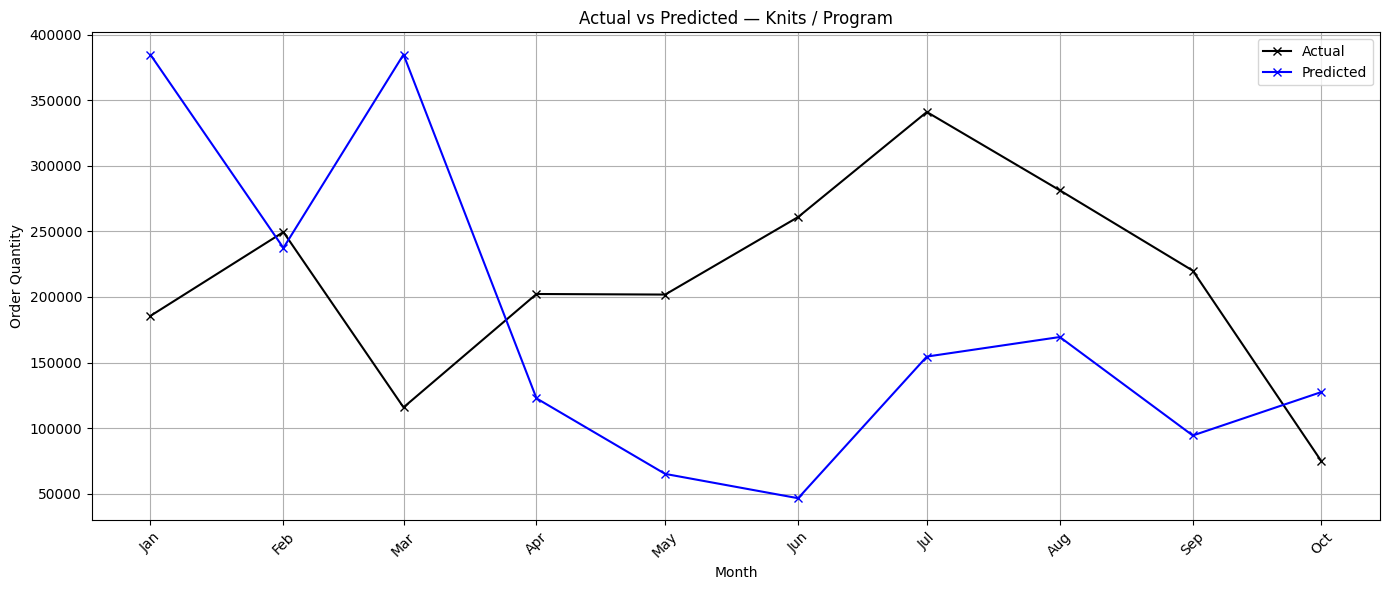

In [413]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fabrics = 'Knits'
season = 'Program'

df_pivot = plot_df[(plot_df['FABRIC_TYPE'] == fabrics) &
                   (plot_df['SEASON_CONSOLIDATION'] == season)]

df_pivot = df_pivot.sort_values("DATE")

plt.figure(figsize=(14,6))

plt.plot(df_pivot['DATE'], df_pivot['ORDERED_QUANTITY'], 
         'x-',label="Actual", color="black")
plt.plot(df_pivot['DATE'], df_pivot['y_pred'], 
         'x-',label="Predicted", color="blue")

# ★ Show month names
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))   # ← Month name + Year
plt.xticks(rotation=45)

plt.title(f"Actual vs Predicted — {fabrics} / {season}")
plt.xlabel("Month")
plt.ylabel("Order Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [414]:
calculate_metrics(test,y_pred,pairs,cat_cols)

,group,MAE,RMSE,WAPE,COUNT
0,"(Knits, Custom)",144496.00,225083.45,41.15,12
1,"(Knits, Program)",711241.50,1110599.09,273.07,12
2,"(Wovens, Custom)",1127816.17,1446184.26,48.07,12
3,"(Wovens, Program)",927691.83,1190472.66,133.73,12
4,"(Wovens, Stock)",NaN,NaN,NaN,12


## TFT Model Training

In [31]:
pairs

[('Knits', 'Custom'),
 ('Knits', 'Program'),
 ('Wovens', 'Custom'),
 ('Wovens', 'Program'),
 ('Wovens', 'Stock')]

In [32]:
print(df_filled.head())

        DATE FABRIC_TYPE SEASON_CONSOLIDATION  ORDERED_QUANTITY
0 2020-01-01       Knits               Custom            316844
1 2020-02-01       Knits               Custom            509592
2 2020-03-01       Knits               Custom            286176
3 2020-04-01       Knits               Custom             31683
4 2020-05-01       Knits               Custom            185776


In [33]:
df_filled

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2020-01-01,Knits,Custom,316844
1,2020-02-01,Knits,Custom,509592
2,2020-03-01,Knits,Custom,286176
3,2020-04-01,Knits,Custom,31683
4,2020-05-01,Knits,Custom,185776
...,...,...,...,...
295,2024-08-01,Wovens,Stock,40355
296,2024-09-01,Wovens,Stock,7844
297,2024-10-01,Wovens,Stock,281194
298,2024-11-01,Wovens,Stock,86093


In [34]:
df = df_filled.copy()

In [35]:
from sklearn.preprocessing import StandardScaler

df["time_idx"] = df.groupby(["FABRIC_TYPE", "SEASON_CONSOLIDATION"]).cumcount()
df["ORDERED_QUANTITY"] = pd.to_numeric(df["ORDERED_QUANTITY"], errors="coerce").astype(float)
# Scale the target
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df[['ORDERED_QUANTITY']])

In [36]:
df.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,time_idx,target
0,2020-01-01,Knits,Custom,316844.0,0,-0.534487
1,2020-02-01,Knits,Custom,509592.0,1,-0.387820
2,2020-03-01,Knits,Custom,286176.0,2,-0.557823
3,2020-04-01,Knits,Custom,31683.0,3,-0.751473
4,2020-05-01,Knits,Custom,185776.0,4,-0.634220


In [37]:
from pytorch_forecasting import TimeSeriesDataSet

# Window lengths
max_encoder_length = 36    # use past 36 months
max_prediction_length = 12  # predict next 12 months

# Training cutoff
training_cutoff = df['time_idx'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["FABRIC_TYPE","SEASON_CONSOLIDATION"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["target"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(
    training,
    df,
    predict=True,
    stop_randomization=True
)


In [38]:
print(df[['FABRIC_TYPE', 'SEASON_CONSOLIDATION']].dtypes)
print(df[['FABRIC_TYPE', 'SEASON_CONSOLIDATION']].head())
print(df[['FABRIC_TYPE', 'SEASON_CONSOLIDATION']].nunique())


FABRIC_TYPE             object
SEASON_CONSOLIDATION    object
dtype: object
  FABRIC_TYPE SEASON_CONSOLIDATION
0       Knits               Custom
1       Knits               Custom
2       Knits               Custom
3       Knits               Custom
4       Knits               Custom
FABRIC_TYPE             2
SEASON_CONSOLIDATION    3
dtype: int64


In [39]:
train_loader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_loader   = validation.to_dataloader(train=False, batch_size=32, num_workers=0)

print(len(train_loader.dataset), len(val_loader.dataset))


5 5


In [40]:
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,   # ✅ one per quantile
    loss=QuantileLoss(),  # default quantiles = 7
)



/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [41]:
from pytorch_lightning import Trainer

trainer = Trainer(
    max_epochs=50,
    gradient_clip_val=0.1,
    accelerator="cpu",
    logger=False  # or "gpu" if you have CUDA
)

trainer.fit(tft, train_loader, val_loader)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /Volumes/Kaam-Dhanda/NewEra/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      |

/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 67.80it/s, loss=0.193, train_loss_step=0.171, val_loss=0.136, train_loss_epoch=0.171]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 51.25it/s, loss=0.193, train_loss_step=0.171, val_loss=0.136, train_loss_epoch=0.171]


In [42]:
raw_preds, index = tft.predict(
    val_loader, 
    mode="raw", 
    return_index=True
)

pred_tensor = raw_preds["prediction"]   # [B, 12, 7]
print("Index:")
print(index)
print("Pred tensor shape:", pred_tensor.shape)


Index:
   time_idx FABRIC_TYPE SEASON_CONSOLIDATION
0        48       Knits               Custom
1        48       Knits              Program
2        48      Wovens               Custom
3        48      Wovens              Program
4        48      Wovens                Stock
Pred tensor shape: torch.Size([5, 12, 7])


In [43]:
import pandas as pd
import numpy as np

# quantiles in order (default TFT)
quantiles = [0.005, 0.025, 0.165, 0.50, 0.835, 0.975, 0.995]

rows = []

for b in range(len(index)):
    group_ft  = index.iloc[b]["FABRIC_TYPE"]
    group_sea = index.iloc[b]["SEASON_CONSOLIDATION"]
    last_time = index.iloc[b]["time_idx"]

    # next forecast time_idxs
    pred_times = np.arange(last_time+1, last_time+1+pred_tensor.shape[1])

    # inverse-scale predictions
    pred_scaled = pred_tensor[b].detach().numpy()         
    pred_inv = scaler.inverse_transform(pred_scaled)

    # build rows
    for t_idx, qvals in zip(pred_times, pred_inv):
        row = {
            "time_idx": t_idx,
            "FABRIC_TYPE": group_ft,
            "SEASON_CONSOLIDATION": group_sea,
            "p50":  qvals[3],     # median
            "p10":  qvals[1],
            "p90":  qvals[5],
        }
        rows.append(row)

forecast_df = pd.DataFrame(rows)
print(forecast_df.head())


   time_idx FABRIC_TYPE SEASON_CONSOLIDATION           p50            p10  \
0        49       Knits               Custom  296494.03125  153597.984375   
1        50       Knits               Custom  287973.15625  136374.796875   
2        51       Knits               Custom  285146.78125  128259.101562   
3        52       Knits               Custom  284853.09375  124178.039062   
4        53       Knits               Custom  285597.65625  121864.726562   

           p90  
0  763967.5000  
1  767566.5625  
2  772880.5000  
3  778731.3750  
4  784606.9375  


In [44]:
from pandas.tseries.offsets import DateOffset

# 1. Map each group to its earliest date (time_idx = 0)
map_df = (
    df.groupby(["FABRIC_TYPE", "SEASON_CONSOLIDATION"])["DATE"]
      .min()
      .reset_index()
      .rename(columns={"DATE": "START_DATE"})
)

# 2. Merge map back into forecast dataframe
forecast_df = forecast_df.merge(
    map_df,
    on=["FABRIC_TYPE", "SEASON_CONSOLIDATION"],
    how="left"
)

# 3. Compute actual forecast dates using DateOffset
forecast_df["FORECAST_DATE"] = forecast_df.apply(
    lambda row: row["START_DATE"] + DateOffset(months=int(row["time_idx"])),
    axis=1
)

forecast_df.head()


,time_idx,FABRIC_TYPE,SEASON_CONSOLIDATION,p50,p10,p90,START_DATE,FORECAST_DATE
0,49,Knits,Custom,296494.03125,153597.984375,763967.5000,2020-01-01,2024-02-01
1,50,Knits,Custom,287973.15625,136374.796875,767566.5625,2020-01-01,2024-03-01
2,51,Knits,Custom,285146.78125,128259.101562,772880.5000,2020-01-01,2024-04-01
3,52,Knits,Custom,284853.09375,124178.039062,778731.3750,2020-01-01,2024-05-01
4,53,Knits,Custom,285597.65625,121864.726562,784606.9375,2020-01-01,2024-06-01


In [45]:
actual_df = df[['DATE','FABRIC_TYPE','SEASON_CONSOLIDATION','ORDERED_QUANTITY']].copy()

In [46]:
forecast_df = forecast_df.merge(
    actual_df.rename(columns={"DATE": "FORECAST_DATE"}),
    on=["FABRIC_TYPE", "SEASON_CONSOLIDATION", "FORECAST_DATE"],
    how="left"
)


In [47]:
print(forecast_df.head())

   time_idx FABRIC_TYPE SEASON_CONSOLIDATION           p50            p10  \
0        49       Knits               Custom  296494.03125  153597.984375   
1        50       Knits               Custom  287973.15625  136374.796875   
2        51       Knits               Custom  285146.78125  128259.101562   
3        52       Knits               Custom  284853.09375  124178.039062   
4        53       Knits               Custom  285597.65625  121864.726562   

           p90 START_DATE FORECAST_DATE  ORDERED_QUANTITY  
0  763967.5000 2020-01-01    2024-02-01          221276.0  
1  767566.5625 2020-01-01    2024-03-01          458416.0  
2  772880.5000 2020-01-01    2024-04-01          317406.0  
3  778731.3750 2020-01-01    2024-05-01          882522.0  
4  784606.9375 2020-01-01    2024-06-01          512954.0  


In [48]:
import matplotlib.pyplot as plt

def plot_group(fabric_type, season_value):
    """
    Plot actual vs forecast for a specific (FABRIC_TYPE, SEASON_CONSOLIDATION) group.
    """
    # Filter
    g = forecast_df[
        (forecast_df["FABRIC_TYPE"] == fabric_type) &
        (forecast_df["SEASON_CONSOLIDATION"] == season_value)
    ].sort_values("FORECAST_DATE")

    if g.empty:
        print(f"❌ No data found for group: ({fabric_type}, {season_value})")
        return
    
    plt.figure(figsize=(14, 6))

    # Actual values
    plt.plot(
        g["FORECAST_DATE"],
        g["ORDERED_QUANTITY"],
        label="Actual",
        color="black",
        linewidth=2,
    )

    # p50 forecast (median)
    plt.plot(
        g["FORECAST_DATE"],
        g["p50"],
        label="Prediction (p50)",
        color="blue",
        linewidth=2,
    )

    # Uncertainty band p10–p90
    plt.fill_between(
        g["FORECAST_DATE"],
        g["p10"],
        g["p90"],
        color="blue",
        alpha=0.2,
        label="Prediction Range (p10–p90)",
    )

    plt.title(f"TFT Forecast vs Actuals — {fabric_type} | {season_value}")
    plt.xlabel("Date")
    plt.ylabel("Ordered Quantity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [49]:
plot_group("Knits", "Stock")


❌ No data found for group: (Knits, Stock)


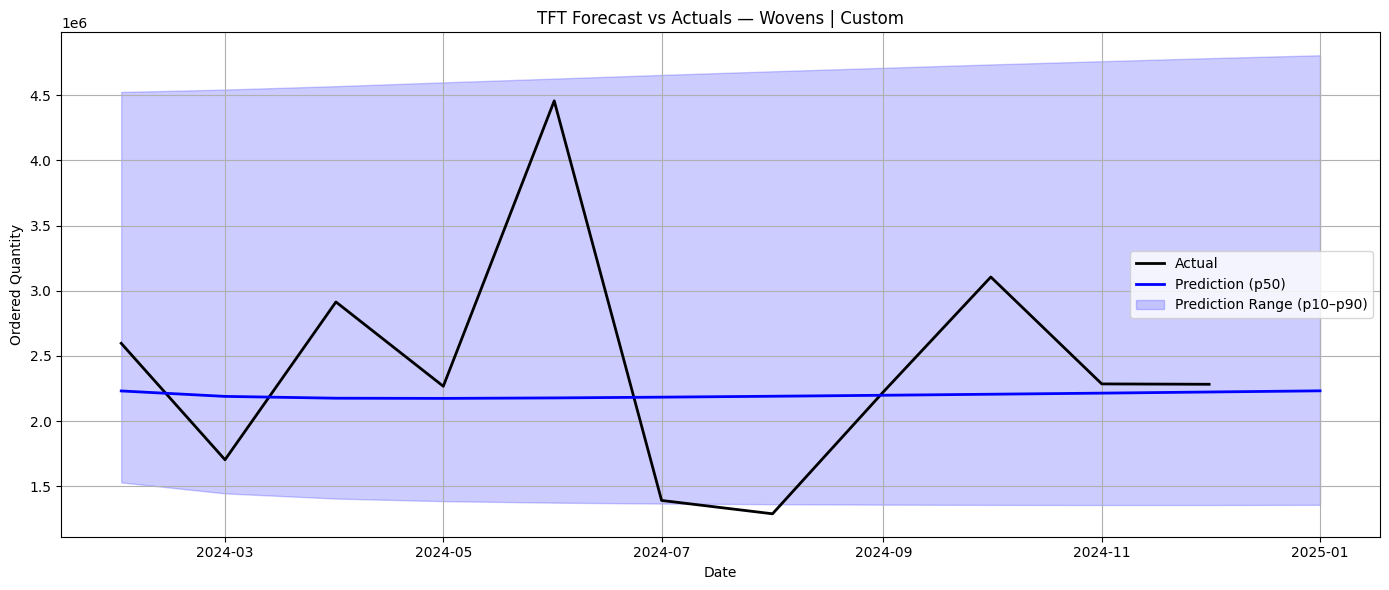

In [53]:
plot_group("Wovens", "Custom")


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Use p50 as main prediction
forecast_df["pred"] = forecast_df["p50"]

# Drop any missing rows
eval_df = forecast_df.dropna(subset=["ORDERED_QUANTITY", "pred"])

y_true = eval_df["ORDERED_QUANTITY"].values
y_pred = eval_df["pred"].values

# Metrics
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
wape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

print("📊 **Forecast Evaluation Metrics (All groups combined)**")
print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"WAPE : {wape:.2f}%")
print(f"Accuracy (1-WAPE): {100-wape:.2f}%")


📊 **Forecast Evaluation Metrics (All groups combined)**
MAE  : 299,875.99
RMSE : 507,889.00
WAPE : 40.01%
Accuracy (1-WAPE): 59.99%


In [55]:
group_mae = (
    forecast_df
    .dropna(subset=["ORDERED_QUANTITY", "p50"])
    .groupby(["FABRIC_TYPE", "SEASON_CONSOLIDATION"])
    .apply(lambda g: mean_absolute_error(g["ORDERED_QUANTITY"], g["p50"]))
)

group_mae


FABRIC_TYPE  SEASON_CONSOLIDATION
Knits        Custom                  142029.468750
             Program                 254670.726030
Wovens       Custom                  610114.931818
             Program                 397457.840909
             Stock                    95106.960760
dtype: float64

### Visualize - TFT

In [56]:
df

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,time_idx,target
0,2020-01-01,Knits,Custom,316844.0,0,-0.534487
1,2020-02-01,Knits,Custom,509592.0,1,-0.387820
2,2020-03-01,Knits,Custom,286176.0,2,-0.557823
3,2020-04-01,Knits,Custom,31683.0,3,-0.751473
4,2020-05-01,Knits,Custom,185776.0,4,-0.634220
...,...,...,...,...,...,...
295,2024-08-01,Wovens,Stock,40355.0,55,-0.744875
296,2024-09-01,Wovens,Stock,7844.0,56,-0.769613
297,2024-10-01,Wovens,Stock,281194.0,57,-0.561614
298,2024-11-01,Wovens,Stock,86093.0,58,-0.710071


In [57]:
fabric = 'Wovens'
season = 'Program'
df_visual = df[(df['FABRIC_TYPE'] == fabric) & (df['SEASON_CONSOLIDATION'] == season)]
string_val = f'United States: Fabric Type: {fabric} & Season Consolidation: {season}'

/Volumes/Kaam-Dhanda/NewEra/main.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
/Volumes/Kaam-Dhanda/NewEra/main.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['DATE'].dt.year
/Volumes/Kaam-Dhanda/NewEra/main.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

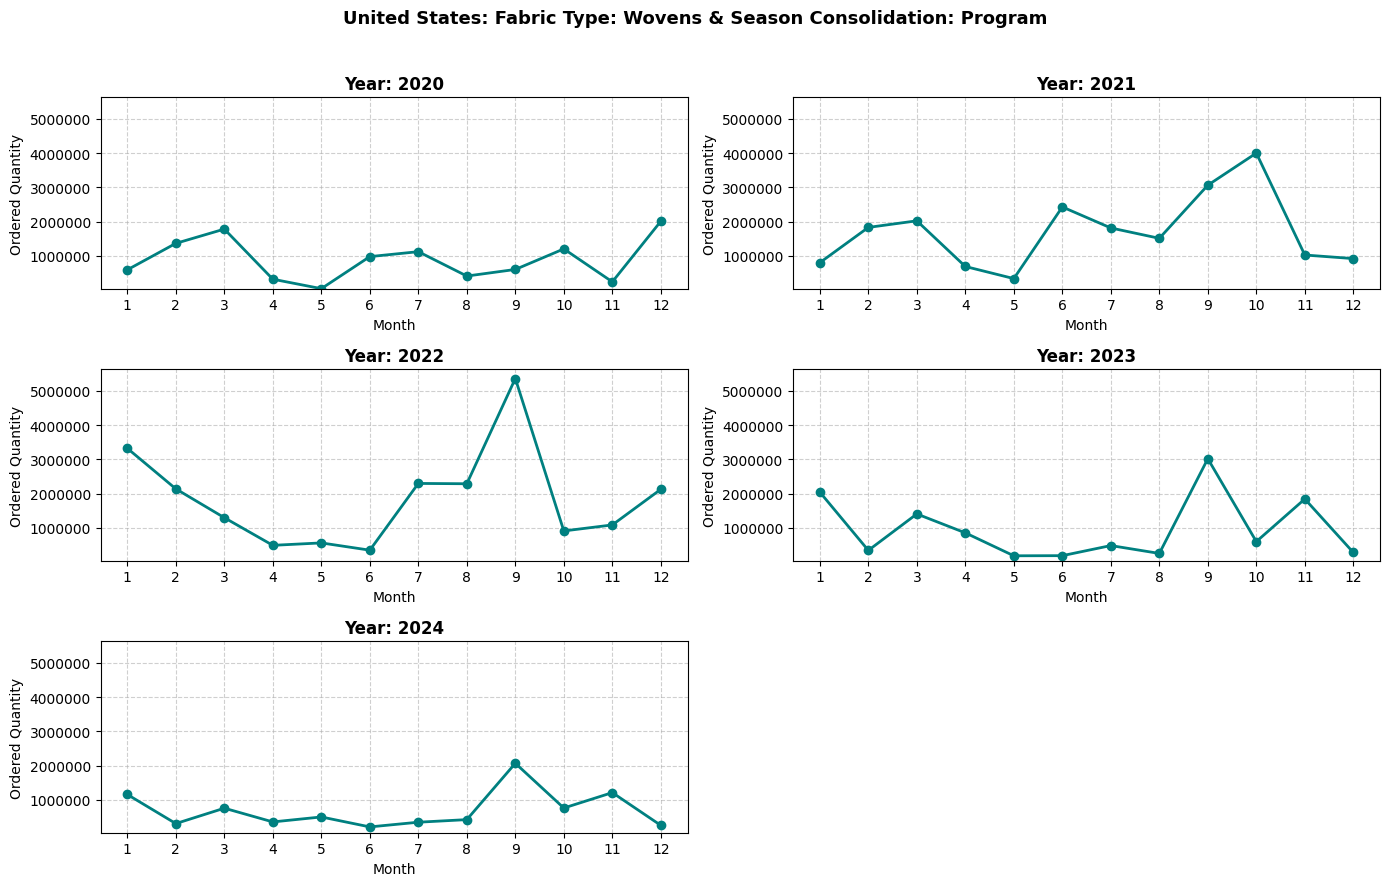

In [58]:
plot_data_by_year_standardized(df_visual, string_val)

In [ ]:
# all cols global

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/snowflake_v5.2_pre_ts.csv')
df.head(2)



# ENHANCED GLOBAL MODEL - ALL CATEGORICAL FEATURES


df['PO_CREATED_DATE'] = pd.to_datetime(df['PO_CREATED_DATE'], format = '%Y%m%d')

print(f"Raw data: {len(df):,} rows | Total sales: {df['ORDERED_QUANTITY'].sum():,.0f}")

# Fill missing categorical values
cat_cols = [
    'REGION', 'COUNTRY', 'SALES_ORG_NAME', 'FABRIC_TYPE','SEASON_CONSOLIDATION',
    'MARKET_SEGMENT', 'GENDER', 'DIVISION_NAME', 'SPORT_UPDATED', 'SILHOUETTE_UPDATED'
]

for col in cat_cols:
    if col in df.columns:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            print(f"Filling {null_count:,} NULLs in {col}")
            df[col] = df[col].fillna('Unknown')

# AGGREGATE TO SEGMENT LEVEL (ALL CATEGORICAL FEATURES)

group_cols = [
    'PO_CREATED_DATE', 'REGION', 'COUNTRY', 'SALES_ORG_NAME',
    'FABRIC_TYPE', 'SEASON_CONSOLIDATION', 'MARKET_SEGMENT', 'GENDER',
    'DIVISION_NAME', 'SPORT_UPDATED', 'SILHOUETTE_UPDATED'
]

# Keep only columns that exist
group_cols = [col for col in group_cols if col in df.columns]

df_segments = df.groupby(group_cols)['ORDERED_QUANTITY'].sum().reset_index()
ts_keys = [col for col in group_cols if col != 'PO_CREATED_DATE']
df_segments = df_segments.sort_values(ts_keys + ['PO_CREATED_DATE'])

print(f"Segment data: {len(df_segments):,} rows | Total Purchases: {df_segments['ORDERED_QUANTITY'].sum():,.0f}")

# Verify no data loss
original_total = df['ORDERED_QUANTITY'].sum()
segment_total = df_segments['ORDERED_QUANTITY'].sum()
data_loss_pct = abs(original_total - segment_total) / original_total * 100

if data_loss_pct < 1:
    print(f"✓ Data preserved ({data_loss_pct:.3f}% difference)")
else:
    print(f"⚠ Warning: {data_loss_pct:.2f}% data loss")


# OUTLIER HANDLING


train_mask = df_segments['PO_CREATED_DATE'] < '2023-01-01'
cap_q = 0.995
cap_value = df_segments.loc[train_mask, 'ORDERED_QUANTITY'].quantile(cap_q)
print(f"Outlier cap ({cap_q}): {cap_value:,.0f}")

df_segments['ORDERED_QUANTITY'] = df_segments['ORDERED_QUANTITY'].clip(lower=0, upper=cap_value)

# FEATURE ENGINEERING


# Time features
df_segments['month'] = df_segments['PO_CREATED_DATE'].dt.month
df_segments['quarter'] = df_segments['PO_CREATED_DATE'].dt.quarter
df_segments['year'] = df_segments['PO_CREATED_DATE'].dt.year
df_segments['month_sin'] = np.sin(2 * np.pi * df_segments['month'] / 12)
df_segments['month_cos'] = np.cos(2 * np.pi * df_segments['month'] / 12)

min_date = df_segments['PO_CREATED_DATE'].min()
df_segments['months_since_start'] = ((df_segments['PO_CREATED_DATE'] - min_date).dt.days / 30.44).astype(int)


# Lag features (by segment)
print("Creating lag features...")
for lag in [1, 2, 3, 6, 12]:
    df_segments[f'lag_{lag}'] = df_segments.groupby(ts_keys)['ORDERED_QUANTITY'].shift(lag)

# Rolling features (by segment)
print("Creating rolling features...")
for window in [3, 6, 12]:
    df_segments[f'rollmean_{window}'] = (
        df_segments.groupby(ts_keys)['ORDERED_QUANTITY']
        .transform(lambda x: x.shift(1).rolling(window).mean())
    )

# EWM features (by segment)
print("Creating EWM features...")
for span in [3, 6]:
    df_segments[f'ewm_{span}'] = (
        df_segments.groupby(ts_keys)['ORDERED_QUANTITY']
        .transform(lambda x: x.shift(1).ewm(span=span).mean())
    )

# Momentum features
df_segments['momentum_3m'] = df_segments['lag_1'] - df_segments['lag_3']
df_segments['momentum_12m'] = df_segments['lag_1'] - df_segments['lag_12']
df_segments['yoy_change'] = df_segments['lag_1'] - df_segments['lag_12']

# Fill missing values
for col in ts_keys:
    df_segments[col] = df_segments[col].fillna('Unknown')
num_cols = df_segments.select_dtypes(include=[np.number]).columns
df_segments[num_cols] = df_segments[num_cols].fillna(0)

print(f"Features created: {len(df_segments.columns)}")

# TRAIN-TEST SPLIT


split_date = '2025-01-01'
train = df_segments[df_segments['PO_CREATED_DATE'] < split_date].copy()
test = df_segments[df_segments['PO_CREATED_DATE'] >= split_date].copy()

print(f"Train: {len(train):,} rows ({train['PO_CREATED_DATE'].min()} to {train['PO_CREATED_DATE'].max()})")
print(f"Test:  {len(test):,} rows ({test['PO_CREATED_DATE'].min()} to {test['PO_CREATED_DATE'].max()})")

drop_cols = ['ORDERED_QUANTITY', 'PO_CREATED_DATE']
X_train = train.drop(columns=drop_cols)
y_train = train['ORDERED_QUANTITY']
X_test = test.drop(columns=drop_cols)
y_test = test['ORDERED_QUANTITY']

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# ENCODE CATEGORICALS


cat_features = X_train.select_dtypes(include='object').columns.tolist()
print(f"Categorical features to encode: {len(cat_features)}")

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    categories = X_train[col].cat.categories
    X_test[col] = pd.Categorical(X_test[col], categories=categories)
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes
    X_test[col] = X_test[col].fillna(-1).astype(int)


# TRAIN MODEL


params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'max_depth': 7,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'random_state': 42
}

print("\nTraining model...")
model = lgb.LGBMRegressor(**params, n_estimators=300)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)]
)

print(f"Model trained. Best iteration: {model.best_iteration_}")

# PREDICTIONS & EVALUATION


y_pred = np.maximum(model.predict(X_test), 0)
test['predicted'] = y_pred

# Train metrics
y_train_pred = np.maximum(model.predict(X_train), 0)
train['predicted'] = y_train_pred
train_agg = train.groupby('PO_CREATED_DATE').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
train_wape = np.abs(train_agg['ORDERED_QUANTITY'] - train_agg['predicted']).sum() / train_agg['ORDERED_QUANTITY'].sum() * 100

# Test metrics
test_agg = test.groupby('PO_CREATED_DATE').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
test_mae = mean_absolute_error(test_agg['ORDERED_QUANTITY'], test_agg['predicted'])
test_rmse = np.sqrt(mean_squared_error(test_agg['ORDERED_QUANTITY'], test_agg['predicted']))
test_wape = np.abs(test_agg['ORDERED_QUANTITY'] - test_agg['predicted']).sum() / test_agg['ORDERED_QUANTITY'].sum() * 100

print("\n" + "="*70)
print("MODEL PERFORMANCE (Monthly Aggregate)")
print("="*70)
print(f"Train WAPE: {train_wape:.2f}%  |  Test WAPE: {test_wape:.2f}%")
print(f"Test MAE:   {test_mae:,.0f}")
print(f"Test RMSE:  {test_rmse:,.0f}")
print(f"Accuracy:   {100 - test_wape:.2f}%")

if test_wape < train_wape * 1.5:
    print("Status:      Good generalization")
else:
    print("Status:      Check for overfitting")
print("="*70)

# Feature importance
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features:")
print(feat_imp.head(15).to_string(index=False))

# DRILL-DOWN ANALYSIS
print("\n" + "="*70)
print("DRILL-DOWN: 2023 Performance")
print("="*70)